# A feedback loop of conditionally stable circuits drives the the cell cycle from checkpoint to checkpoint
Supporting notebook

### Abstract

We analyze a dynamic model of the mammalian cell cycle using logic-based network analysis to uncover how interactions between multi-stable modules (the Phase Switch and Restriction Switch) can yield cyclic dynamics for the system as a whole. We generalize the previously introduced concept of stable motif, i.e., a self-sustaining positive feedback loop, and introduce the concept of conditionally stable motif, the stability of which is contingent on an external condition. We show that the stable motifs of the Phase Switch are contingent on the state of three nodes through which it receives input from the rest of the network. Holding these nodes locked transforms the Phase Switch into an autonomous oscillator that robustly toggles through the cell cycle phases G1, G2 and mitosis. The conditionally stable motifs of the Phase Switch Oscillator  are organized into an ordered sequence, such that they serially stabilize each other but also cause their own destabilization. As the requirements of each conditionally stable motif are met, they channel the dynamics of the module along a narrow path in state space, lending robustness to the oscillation. The network around the Phase Switch provides the conditions that stabilize its stable motifs. Biologically, these conditions correspond to cell cycle checkpoints. Passage through each checkpoint destabilizes the respective stable motif. Thus, the Phase Switch balances the need to stably maintain the cell at each checkpoint with the need for a robust limit cycle when checkpoints are cleared without issue. 


In [1]:
import sys

sys.path.append('BooleanDOI-master/')
import boolean2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import BooleanDOI_processing as BDOIp
import BooleanDOI_TargetControl as BDOItc
import BooleanDOI_DOI as BDOI

import cool_bool_tools as cbt


Bad key "text.kerning_factor" on line 4 in
/home/david/anaconda2/envs/python_3_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## The Phase Switch Oscillator - Simulations and analysis

### Synchronous update

In [2]:
#reading in the rules
model_name='PSO'
rules=cbt.read_rules_text(model_name)

model_sync = boolean2.Model(rules, mode='sync')
nodes=model_sync.nodes
model_sync.initialize(lambda node: True) #everything on state (it can be any random state)

model_sync.iterate(27) #we iterate enough so the model enters the attractor
cycle_start, cycle_length=model_sync.detect_cycles()
model_sync.iterate(cycle_start+cycle_length) #

cell_cycle_states_indexed=dict(zip(range(10),model_sync.states[-(cycle_length+1):]))
cell_cycle_states=model_sync.states[-(cycle_length+1):]

We compare the states of the PSO with the attractors of the Phase Switch model. These are loaded from a file. In the cell below we calculate the overlap of the states of the PSO limit cycle with the three PS attractor states.


In [3]:
PS_attractors=cbt.read_in_attractors('phase_switch')
module_attractors={}
module_attractors['G0/G1']=PS_attractors.pop('Attractor0')
module_attractors['SAC']=PS_attractors.pop('Attractor1')
module_attractors['G2']=PS_attractors.pop('Attractor2')


closest_module_attractor={}
overlap_to_module_attractors_all_three={}

N=len(model_sync.nodes)
for n,sync_state in cell_cycle_states_indexed.items():
    overlaps={}
    for attr,state in module_attractors.items():
        overlap=cbt.partial_overlap_of_states(state,sync_state)
        overlaps[attr]=overlap
        
    overlap_to_module_attractors_all_three[n]=(int(overlaps['G0/G1']*N),int(overlaps['G2']*N),int(overlaps['SAC']*N))
    
    l=overlaps.values()
    if len([i for i in l if i==max(l)])==1:
        closest_module_attractor[n]=max(overlaps, key=overlaps.get)
    else:
        closest_module_attractor[n]='multiple'

In [4]:
overlap_to_module_attractors_all_three

{0: (8, 3, 2),
 1: (7, 4, 1),
 2: (5, 6, 3),
 3: (2, 7, 6),
 4: (1, 6, 7),
 5: (1, 4, 7),
 6: (2, 3, 6),
 7: (5, 2, 3),
 8: (6, 3, 4),
 9: (8, 3, 2)}

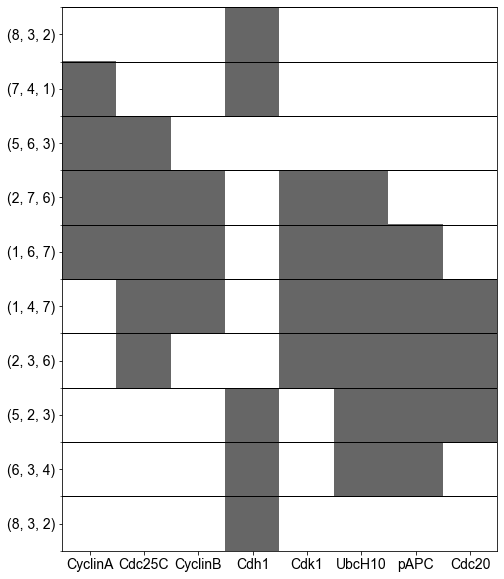

In [5]:
plt.rcParams["font.family"] = "Arial"
node_order=['CyclinA','Cdc25C','CyclinB', 'Cdh1', 'Cdk1', 'UbcH10', 'pAPC', 'Cdc20']
state_labels=[overlap_to_module_attractors_all_three[i] for i in range(len(cell_cycle_states))]

cbt.plot_state_succession(cell_cycle_states,nodes=node_order, state_labels=state_labels,state_colors=['white', '#666666'],y_fontsize=14,x_fontsize=14)

## The complex attractor emerging from general asynchronous update

In [6]:
import random

def general_async_pick( lines ):
    line = [ random.choice( lines )]
    return line

In [7]:
model_async = boolean2.Model(rules, mode='async')
nr_of_steps=100000
node_threshold=500
#complex attractor

start_state=cell_cycle_states[0]

model_async.initialize(lambda node: start_state[node])
model_async.iterate(nr_of_steps,shuffler=general_async_pick)

#(filtering as a param)

In [8]:
tg=cbt.TransGraph(logfile='states.txt')
tg.add(model_async.states)
G=tg.graph
print ('Number of nodes in the sample STG:',G.number_of_nodes())
print ('Number of edges in the sample STG:',G.number_of_edges())

Number of nodes in the sample STG: 67
Number of edges in the sample STG: 205


Counting the node and edge visitations

In [9]:
from collections import Counter
fp_states=model_async.fp()
state_occurances=Counter(fp_states)
edge_occurances=Counter([(fp_states[i-1], fp_states[i]) for i in range(len(fp_states))])


Filtering out nodes with visitation number smaller than *node_threshold*

In [10]:
filtered_nodes=[]
for n in G.nodes():
    if state_occurances[n]>node_threshold:
        filtered_nodes.append(n)
        
len(filtered_nodes)
g=nx.subgraph(G,filtered_nodes)  


Calculationg overlap with the module attractors:

In [11]:
fp_state_dict=dict(zip(model_async.fp(),model_async.states))
overlap_to_module_attractors={}
overlap_to_module_attractors_all_three={}
closest_module_attractor={}
N=len(model_async.nodes)
for n in g.nodes:
    async_state=fp_state_dict[n]
    overlaps={}
    for attr,state in module_attractors.items():
        overlap=cbt.partial_overlap_of_states(state,async_state)
        overlaps[attr]=overlap
        
    overlap_to_module_attractors[n]=max(overlaps.values())
    overlap_to_module_attractors_all_three[n]=(int(overlaps['G0/G1']*N),int(overlaps['G2']*N),int(overlaps['SAC']*N))
    
    l=overlaps.values()
    if len([i for i in l if i==max(l)])==1:
        closest_module_attractor[n]=max(overlaps, key=overlaps.get)
    else:
        closest_module_attractor[n]='multiple'
    

attractor_colormap={'G0/G1':'blue','G2':'orange','SAC':'brown', 'multiple':'grey'}
node_colors=[attractor_colormap[closest_module_attractor[i]] for i in g.nodes()]
node_alpha=[overlap_to_module_attractors[i] for i in g.nodes()]
node_labels={i:closest_module_attractor[i] for i in g.nodes()}

We also create a subgraph of for the edges of the synchronous update, so we can see how it relates to the general asynchrnous state transition graph

In [12]:
g_sync_nodes_fp=[]
for cs in cell_cycle_states:
	for j in fp_state_dict.items():
		if cs==j[1]:
			g_sync_nodes_fp.append(j[0])
g_sync=nx.DiGraph()
g_sync.add_edges_from([(g_sync_nodes_fp[i],g_sync_nodes_fp[i+1]) for i in range(len(g_sync_nodes_fp)-1)])
g_sync.add_edge(g_sync_nodes_fp[-1],g_sync_nodes_fp[0]) #closing the loop

Plotting the sample STG

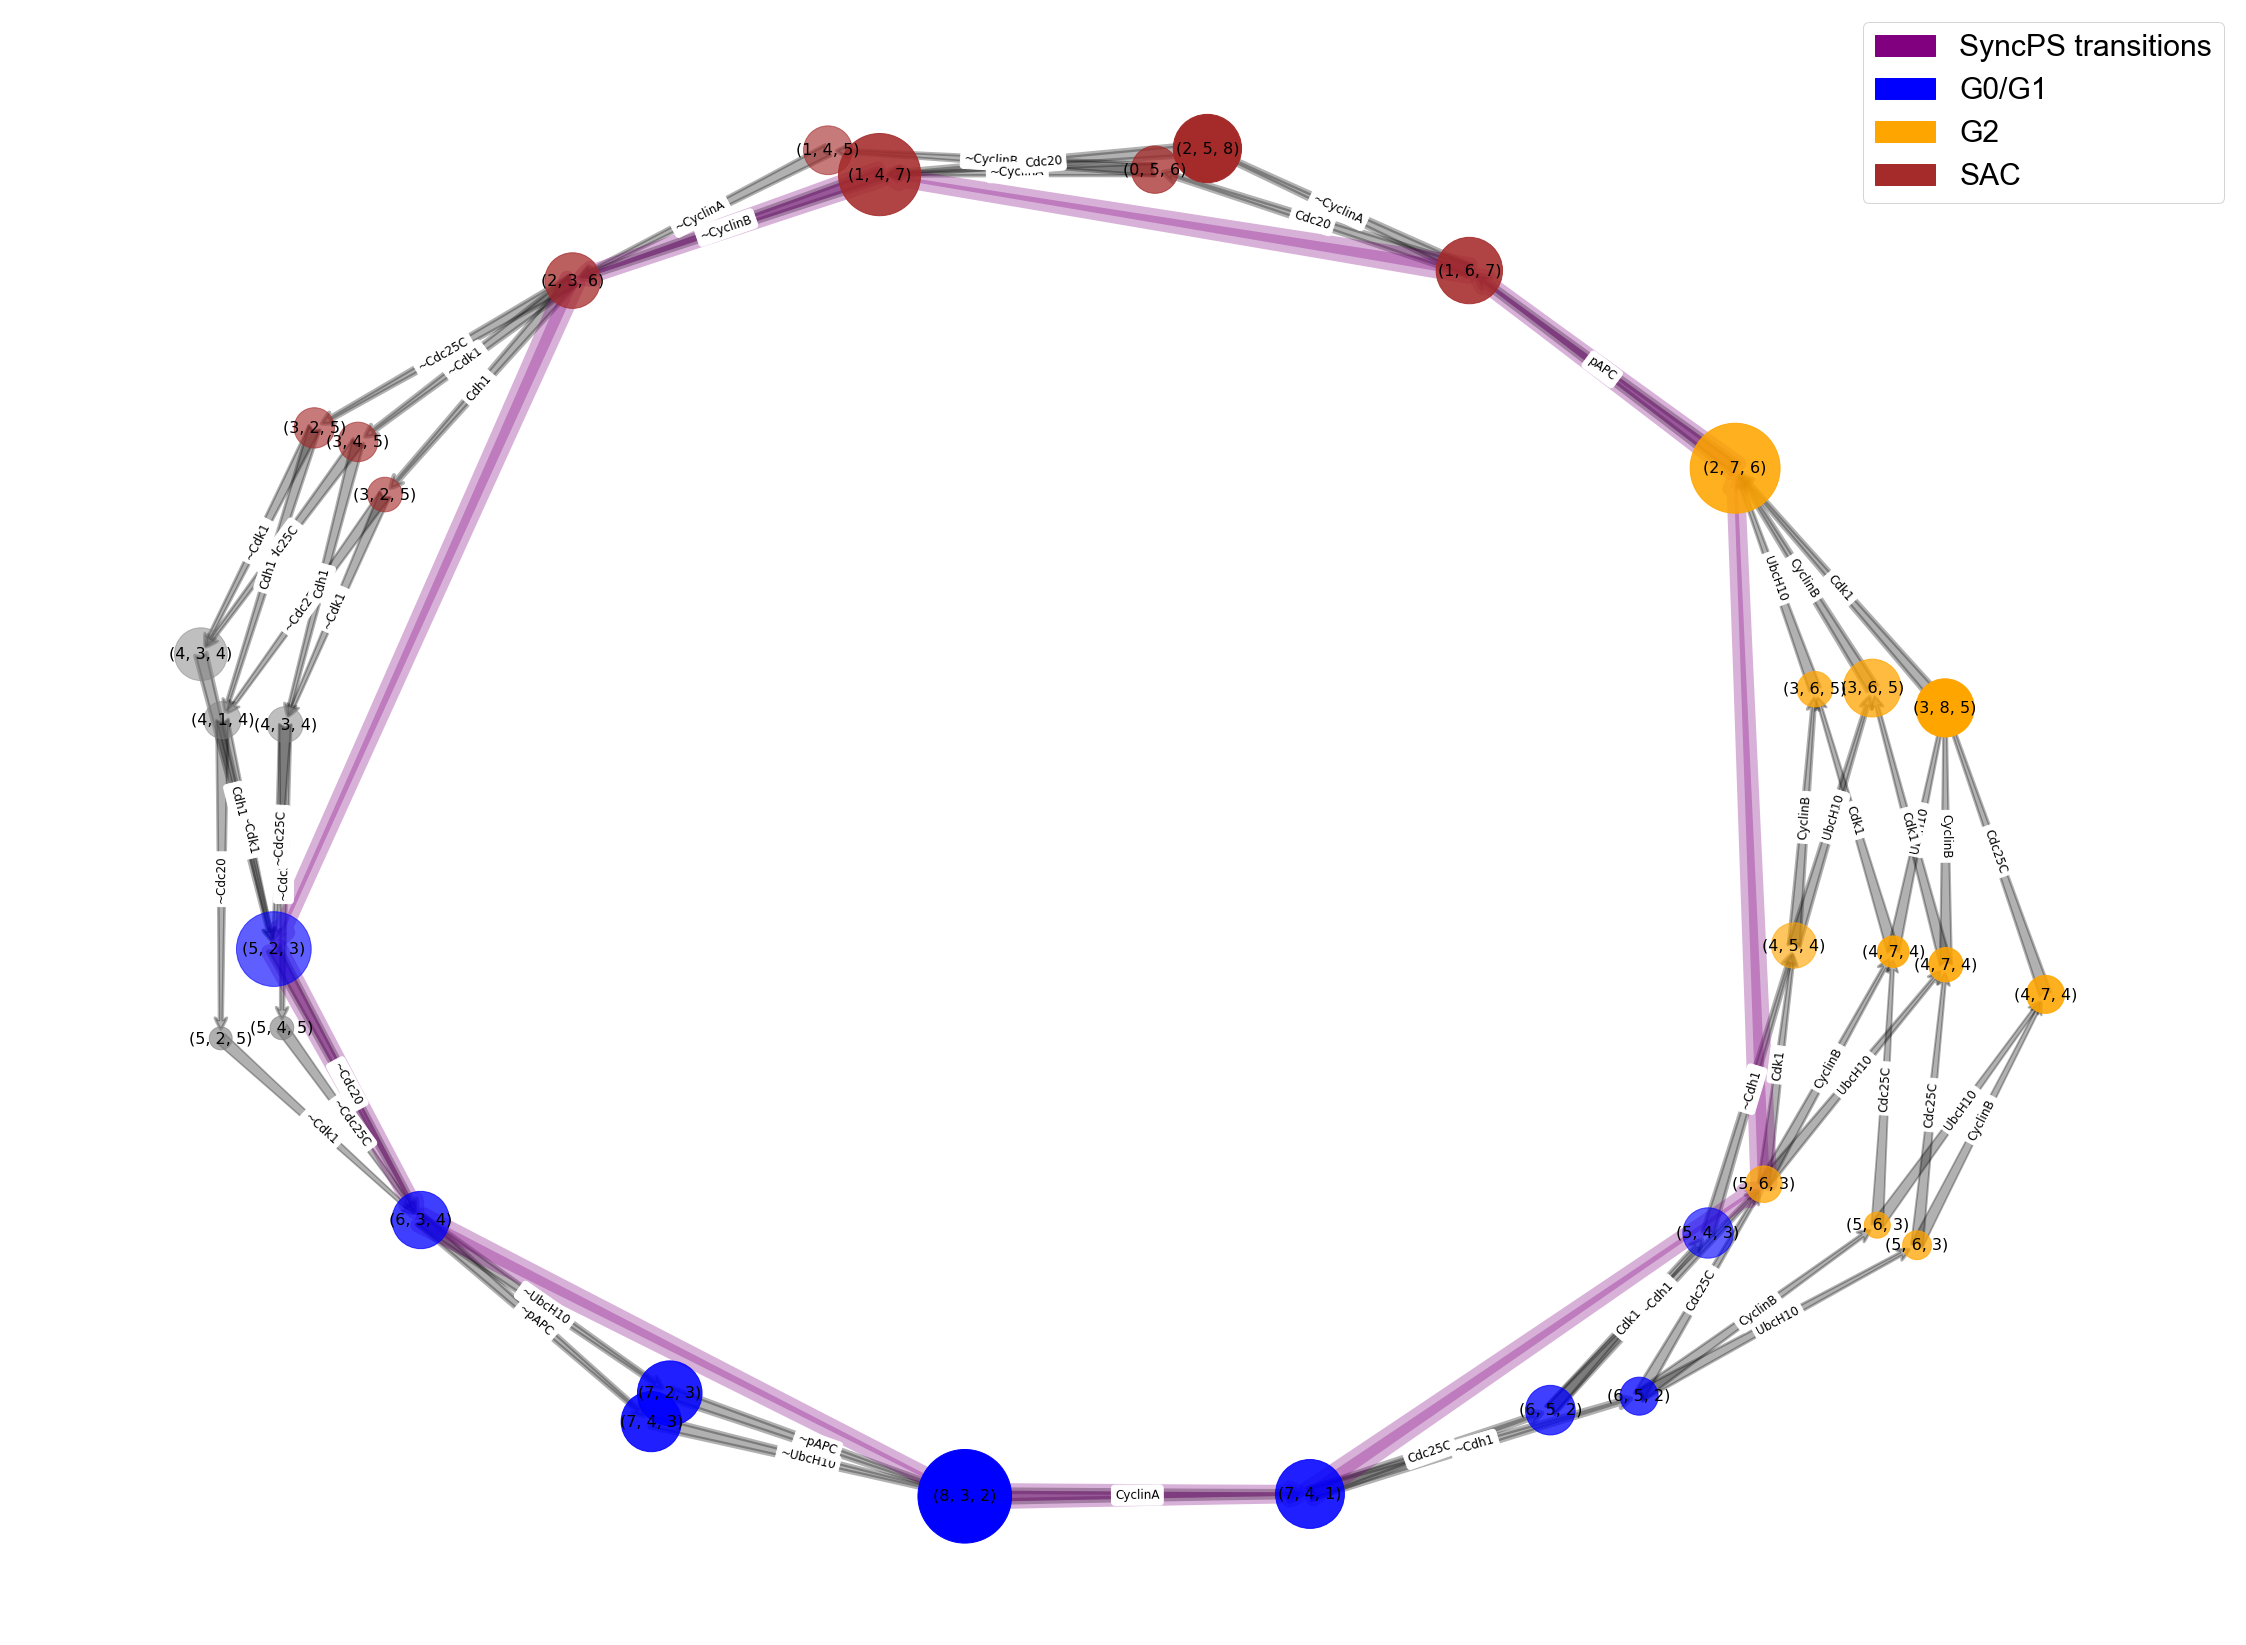

In [13]:

#EDGE LABEL
edge_labels={}
for e in list(g.edges()):
    changing_nodes=[i for i in fp_state_dict[e[0]].keys() if fp_state_dict[e[0]][i]!=fp_state_dict[e[1]][i]]
    if len(changing_nodes)==1:
        edge_labels[e]=changing_nodes[0]
        if not bool(fp_state_dict[e[1]][changing_nodes[0]]):
            edge_labels[e]='~'+edge_labels[e]
    else:
        edge_labels[e]=''


#OTHER PARAMS
edge_label_font_size=12
node_label_font_size=16

edge_alpha=0.3
edge_weights=[np.sqrt(float(edge_occurances[i]))/5 for i in g.edges()]
fig_dimensions=(40,30)

node_weights=[float(state_occurances[j]) for j in g.nodes()]

plot_name='complex_attractor_with_overlaps'

plt.figure(figsize=fig_dimensions)
pos=nx.layout.kamada_kawai_layout(g)
ec = nx.draw_networkx_edges(g, pos, alpha=edge_alpha,with_labels=False,width=edge_weights,arrowstyle='fancy',arrowsize=30)

el = nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,font_size=edge_label_font_size)
e_ss = nx.draw_networkx_edges(g_sync, pos, alpha=edge_alpha,with_labels=False,width=15,edge_color='purple',arrowstyle='fancy',arrowsize=30)

lc  = nx.draw_networkx_labels(g,pos,overlap_to_module_attractors_all_three,font_size=node_label_font_size)
nc = nx.draw_networkx_nodes(g, pos,alpha=node_alpha,node_color=node_colors, node_size=node_weights)
plt.axis('off')
#LEGEND
import matplotlib.patches as mpatches
purple_patch = mpatches.Patch(color='purple', label='SyncPS transitions')
blue_patch = mpatches.Patch(color='blue', label='G0/G1')
orange_patch = mpatches.Patch(color='orange', label='G2')
brown_patch = mpatches.Patch(color='brown', label='SAC')

plt.legend(fontsize=30,handles=[purple_patch,blue_patch,orange_patch,brown_patch])

#plt.savefig(plot_name+'.png')
#plt.savefig(plot_name+'.pdf')
plt.show()

## Generating the full STG of the PSO model

This is possible with a smaller model as the PSO as it only has $2^8=256$ states, but in case of larger mosels this procedure is untractable thusthe sampling procedre used above is a more viable solution.

In [14]:
g,edge_occurances,state_occurances,fp_state_dict=cbt.get_async_STG_all_states(model_async,node_threshold=0)
assert g.number_of_nodes()==2**len(model_async.nodes)

We extract the largest strongly connected componnent of the STG - the complex attractor

In [15]:
largest = max(nx.strongly_connected_components_recursive(g), key=len)
print (len(largest))
g=g.copy().subgraph(largest)

141


In [16]:
G=nx.DiGraph()
G.add_edges_from(g.edges()) # the TransGraph function returns a multigraph, that the PR algorithm cannot handle
pr=nx.pagerank(G,alpha=0.95,max_iter=1000)

## Backbone of the oscillation 
For the explanation of the "backbone" algorithm see *Methods - Coarse-graining the complex attractor based on established proxy states*. Here we include the python implementation of the algorithm.

The proxy nodes of the corase grained complex attractor will be the synchrnoous states - to see how well the complex attractor follows them.

In [17]:
PNs=g_sync_nodes_fp[:-1] #we don't need the closed loop, so I remove the last state which is also the first state

We perform the analysis on the largest SCC of the full STG

In [18]:
g,edge_occurances,state_occurances,fp_state_dict=cbt.get_async_STG_all_states(model_async,node_threshold=0)
largest = max(nx.strongly_connected_components_recursive(g), key=len)
print (len(largest))
g=g.subgraph(largest).copy()
#we also remove the selfloops in this case
for e in list(g.edges()):
    if e[0]==e[1]:
        g.remove_edge(e[0],e[1])

141


The algorithm uses the networkx implementation of the simple_paths algorithm, that determines all the paths between two nodes that have no repeting nodes in them. The tractability of finding all paths between two nodes within graphs of this nature can get out of hand fairly quickly, so we set a path-length-cutoff, which will be set to 16.
We choose this number based on the fact that this is the minimum number of steps that are required to have all nodes change and get back into their original states. Anything path longer than 16 involves multiple changes of at least one node. 

In [19]:
cutoff=16
G_BB,G_BB_edge_weights=cbt.STG_backbone_based_on_proxy_nodes(g,PNs,cutoff=16)

## Saving the backbone data into a table

In [20]:
changing_nodes_all={}
for e in g.edges():
    if e[0]==e[1]:
        continue
    changing_node=[i for i in fp_state_dict[e[0]].keys() if fp_state_dict[e[0]][i]!=fp_state_dict[e[1]][i]][0]
    if fp_state_dict[e[1]][changing_node]==False:
        changing_node="~"+changing_node
    changing_nodes_all[e]=changing_node
    
changing_nodes_BB={}
for e in G_BB.edges():
    if e[0]==e[1]:
        continue
    changing_nodes_BB[e]=[]
    changing_nodes=[i for i in fp_state_dict[e[0]].keys() if fp_state_dict[e[0]][i]!=fp_state_dict[e[1]][i]]
    for changing_node in changing_nodes:
        if fp_state_dict[e[1]][changing_node]==False:
            changing_node="~"+changing_node
        changing_nodes_BB[e].append(changing_node)

ew_list=[]
PN_path_changes={}
for source_PN, target_PN in G_BB.edges():
    PN_set=set(PNs)
    PN_set.remove(source_PN)
    PN_set.remove(target_PN)
    number_of_paths=0
    path_changes=[]
    for path in nx.all_simple_paths(g,source_PN,target_PN, cutoff=11):
        if len(set(path).intersection(PN_set))==0:
            edges_on_the_path=list(zip(path[:-1],path[1:]))
            path_changes.append([changing_nodes_all[e] for e in edges_on_the_path]) 
            assert edges_on_the_path[-1][1] == target_PN

        number_of_paths+=1
    PN_path_changes[(source_PN,target_PN)]=path_changes
    
PN_paths_no_order={}
for pair,p in PN_path_changes.items():
    if len(p)==0:
        PN_paths_no_order[pair]=[]
        continue
    PN_paths_no_order[pair]=[]
    base=p[0]
    PN_paths_no_order[pair].append(base)
    for pp in p:
        if sorted(pp)==sorted(base):
            continue
        else:
            new_base=True
            for ppp in PN_paths_no_order[pair]:
                if sorted(pp)==sorted(ppp):
                    new_base=False
            
            if new_base:        
                base=pp
                PN_paths_no_order[pair].append(base)
                
for e, w in G_BB_edge_weights.items():
    ew_list.append([overlap_to_module_attractors_all_three[e[0]],overlap_to_module_attractors_all_three[e[1]], w, PN_paths_no_order[e]])
import pandas as pd
df_ew=pd.DataFrame(ew_list,columns=['Source','Target','Transition probability', 'Changing nodes and paths (no order permutations)'])
df_ew.to_excel('Backbone_edges.xlsx')

In [21]:
df_ew.head()

,Source,Target,Transition probability,Changing nodes and paths (no order permutations)
0,"(8, 3, 2)","(7, 4, 1)",1.000000,[[CyclinA]]
1,"(7, 4, 1)","(8, 3, 2)",0.007239,[]
2,"(7, 4, 1)","(5, 6, 3)",0.416750,"[[~Cdh1, Cdc25C]]"
3,"(7, 4, 1)","(2, 7, 6)",0.500019,"[[~Cdh1, CyclinB, Cdc25C, Cdk1, UbcH10]]"
4,"(7, 4, 1)","(1, 6, 7)",0.027778,"[[~Cdh1, CyclinB, Cdc25C, Cdk1, pAPC, UbcH10]]"


### A network representation of the backbone
We filter the backbone representation and plot it.

In [22]:
p_threshold=0.05 #meta edges with lower probability will be removed for simplicity.

for e in list(G_BB.edges()):
    if G_BB_edge_weights[e] <p_threshold:
        G_BB.remove_edge(e[0],e[1])

(-0.7632063234458405,
 0.6986426936794031,
 -1.1932101707918912,
 1.033307035476569)

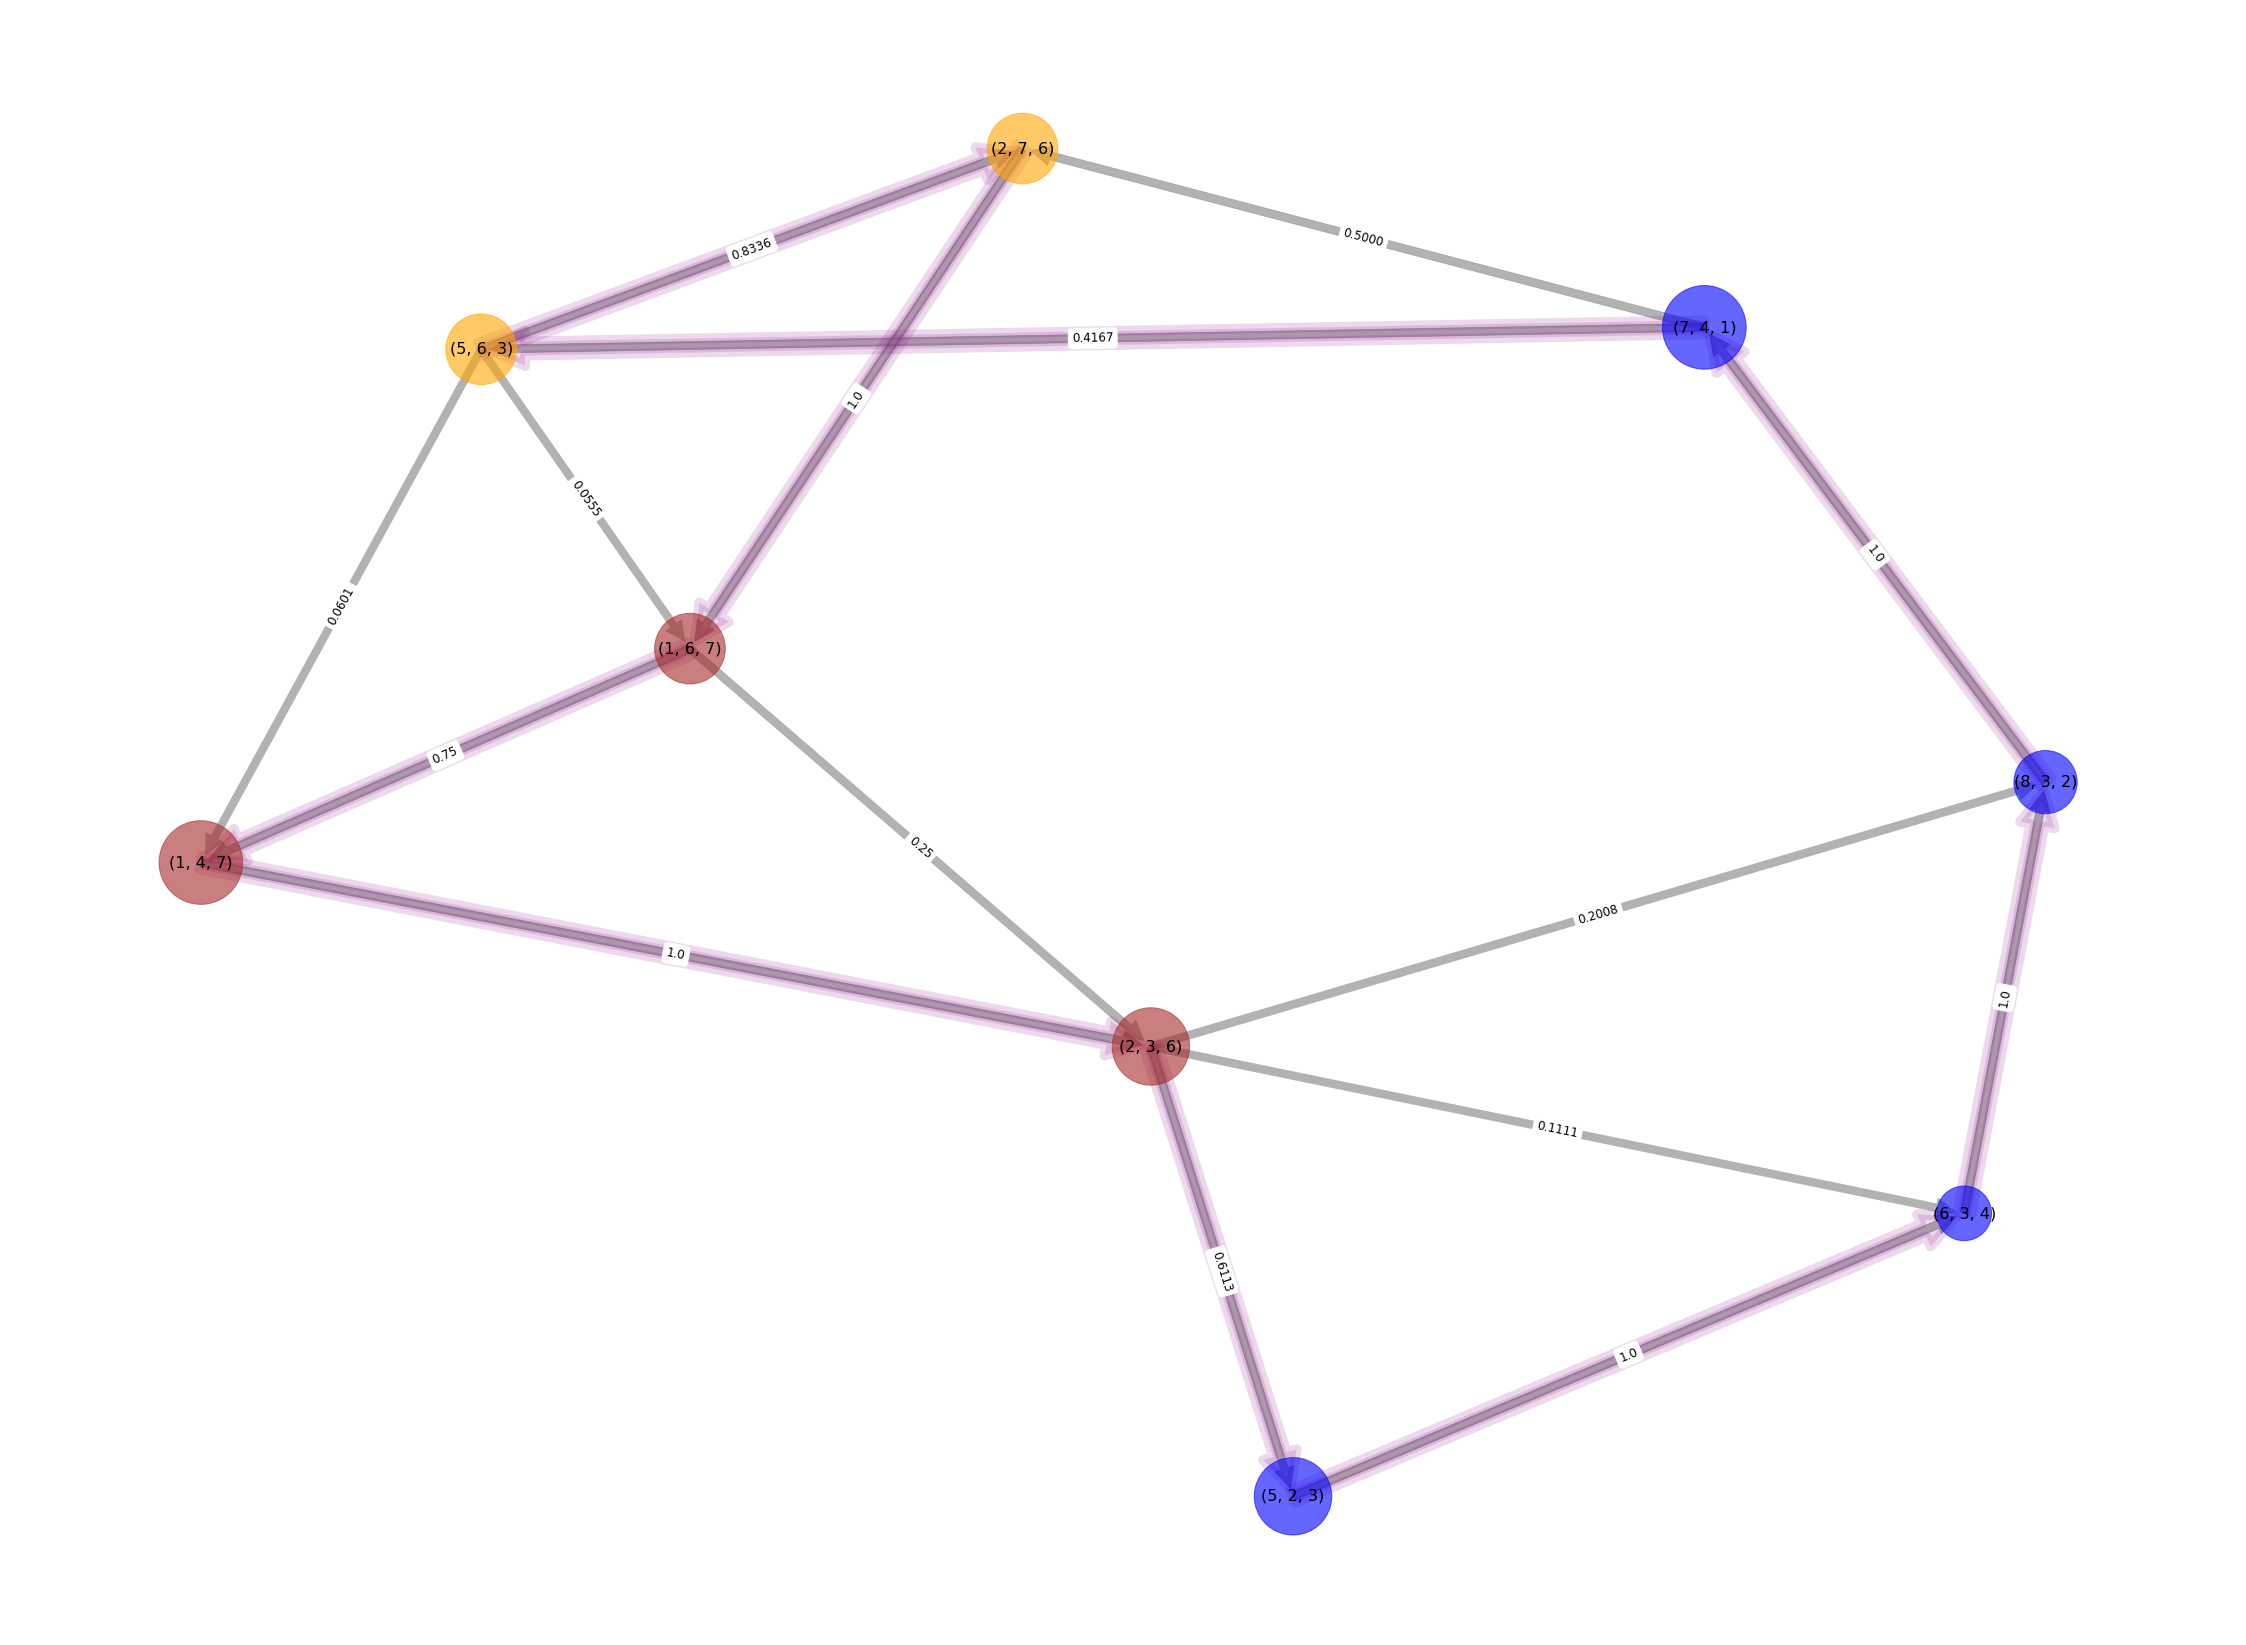

In [23]:
node_scaling=100
plt.figure(figsize=fig_dimensions)
pos =nx.kamada_kawai_layout(G_BB)

node_colors=[attractor_colormap[closest_module_attractor[i]] for i in G_BB.nodes()]
edge_labels={e:str(G_BB_edge_weights[e])[:6] for e in G_BB.edges()}
node_weights=[float(state_occurances[j])*node_scaling*5 for j in g.nodes()]

ec = nx.draw_networkx_edges(G_BB, pos,width=[np.sqrt(G_BB_edge_weights[e]) for e in G_BB.edges()],edge_color='grey',alpha=0.6,arrowsize=40, arrowstyle='simple')
e_ss = nx.draw_networkx_edges(g_sync, pos, alpha=0.15,with_labels=False,width=10,edge_color='purple',arrowsize=70, arrowstyle='simple')

el = nx.draw_networkx_edge_labels(G_BB, pos, edge_labels={e:str(G_BB_edge_weights[e])[:6] for e in G_BB.edges()},font_size=edge_label_font_size)
lc  = nx.draw_networkx_labels(G_BB,pos,{i:overlap_to_module_attractors_all_three[i] for i in G_BB.nodes()},font_size=node_label_font_size)
nc = nx.draw_networkx_nodes(G_BB, pos ,node_color=node_colors, node_size=node_weights,alpha=0.6)
#plt.colorbar(nc, label='Overlap with the closest SyncCC state')
plt.axis('off')

## The Expanded network of the PSO

In [24]:
import BooleanDOI_processing as BDOIp

import BooleanDOI_TargetControl as BDOItc

import BooleanDOI_DOI as BDOI

In [25]:
model_name='PSO'

G_expanded=cbt.read_and_create_extended_network(model_name+'.txt')

We plot the expanded network in such a way, that the composite nodes are the small black circles while the virtual nodes are the larger, labelled circles

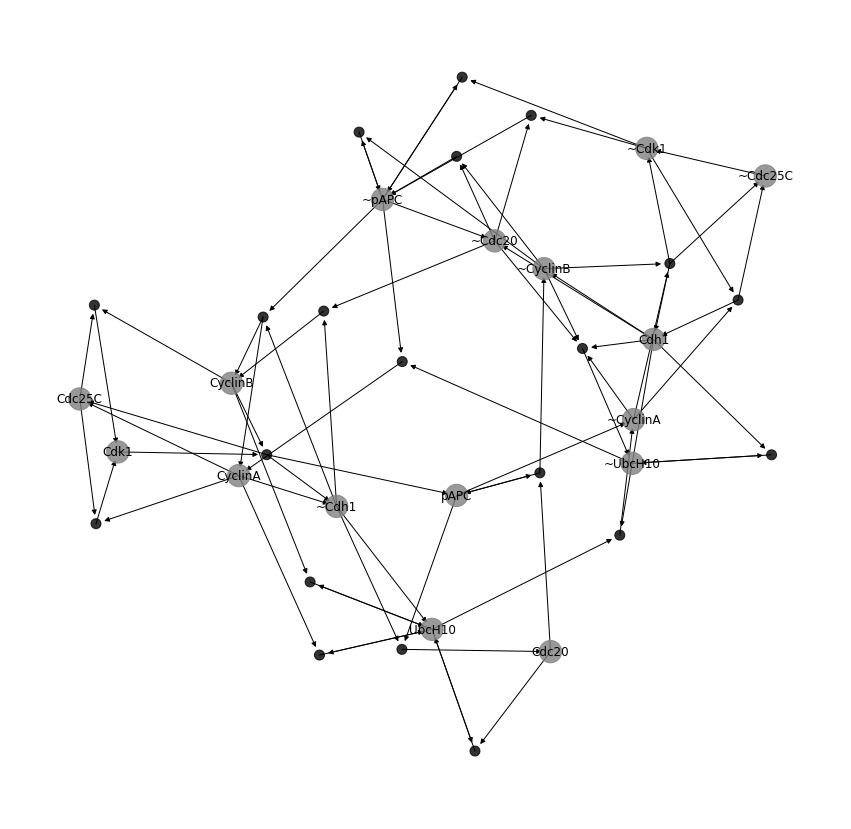

In [26]:
plt.figure(figsize=(15,15))
pos = nx.layout.kamada_kawai_layout(G_expanded)  # positions for all nodes
nx.draw_networkx_nodes(G_expanded,pos,alpha=0.8, node_size=[100 if '_' in i else 500 for i in G_expanded.nodes()],node_color=['black' if '_' in i else 'grey' for i in G_expanded.nodes()])
nx.draw_networkx_edges(G_expanded, pos)

# labels
nx.draw_networkx_labels(G_expanded, pos, labels={i:'' if '_' in i else i for i in G_expanded})

plt.axis('off')
plt.show()


In [27]:
#cycles of the expanded network
#conditionally stable motif - table generated

### Finding the conditionally stable motifs in the expanded network of the PSO

In [28]:
CSMs=[]
for i in list(nx.simple_cycles(G_expanded)):
    if cbt.are_subsets_consistent(i,i):
        CSMs.append(i)
        
print (len(CSMs))

28


Inputs of composite nodes that are not in the cycle are conditions:

In [29]:
CSM_list=[]
for csm in CSMs:
    conditions=[]
    for n in csm:
        if '_' in n:
            for cc in n.split('_'):
                if cc not in csm:
                    conditions.append(cc)
    CSM_list.append([csm, conditions])


CSMs with a single condition:   

['~CyclinB', '~CyclinA_~CyclinB', '~Cdk1', '~Cdk1_~CyclinA', 'Cdh1'] condition: {'~CyclinA'}


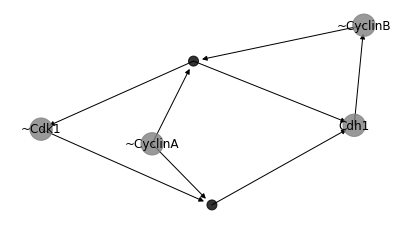

['~CyclinB', '~CyclinA_~CyclinB', '~Cdc25C', '~Cdk1', '~Cdk1_~CyclinA', 'Cdh1'] condition: {'~CyclinA'}


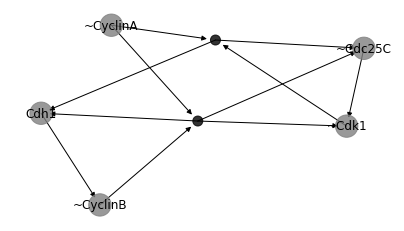

['~CyclinB', '~CyclinA_~CyclinB', 'Cdh1'] condition: {'~CyclinA'}


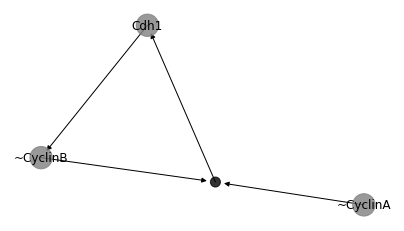

['~Cdk1_~Cdc20', '~pAPC', '~Cdc20'] condition: {'~Cdk1'}


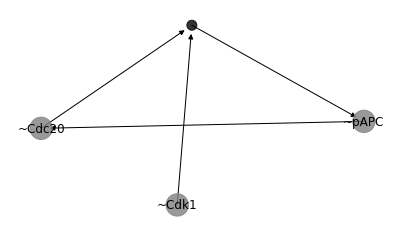

['Cdc25C', 'Cdc25C_CyclinB', 'Cdk1', 'Cdk1_CyclinB'] condition: {'CyclinB'}


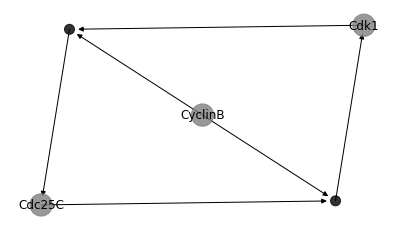

['~CyclinB_~pAPC', '~pAPC'] condition: {'~CyclinB'}


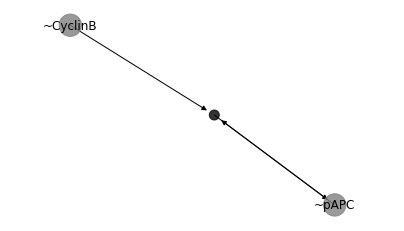

['Cdc20', 'Cdc20_pAPC', 'pAPC', '~Cdh1_pAPC'] condition: {'~Cdh1'}


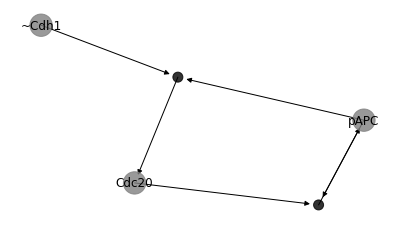

['Cdc20_pAPC', 'pAPC'] condition: {'Cdc20'}


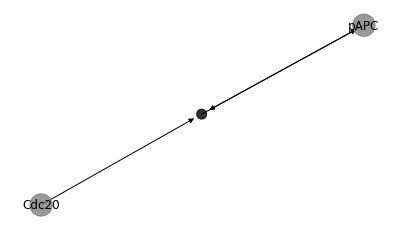

['~Cdh1', '~Cdh1_~pAPC', 'CyclinA'] condition: {'~pAPC'}


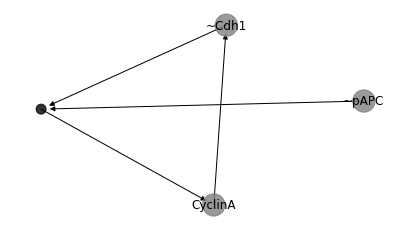

['~UbcH10', '~UbcH10_Cdh1'] condition: {'Cdh1'}


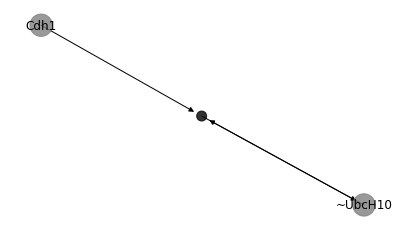

['~Cdk1_~pAPC', '~pAPC'] condition: {'~Cdk1'}


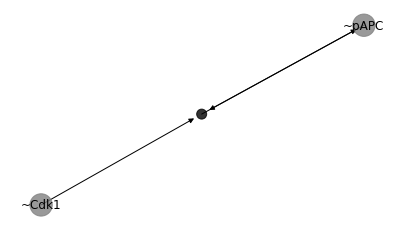

['~pAPC', '~Cdc20', '~CyclinB_~Cdc20'] condition: {'~CyclinB'}


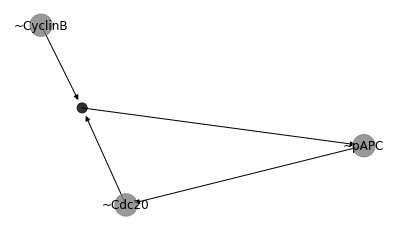

['~Cdk1_~CyclinA', '~Cdc25C', '~Cdk1'] condition: {'~CyclinA'}


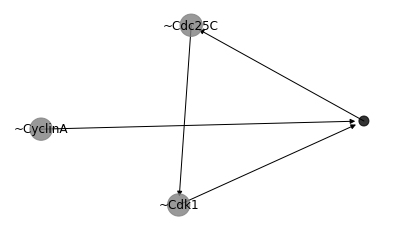

['UbcH10_CyclinB', 'UbcH10'] condition: {'CyclinB'}


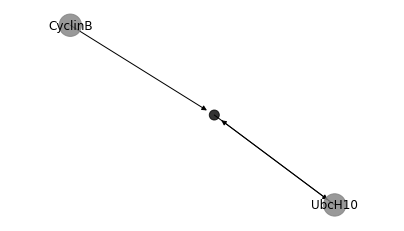

['Cdc20_UbcH10', 'UbcH10'] condition: {'Cdc20'}


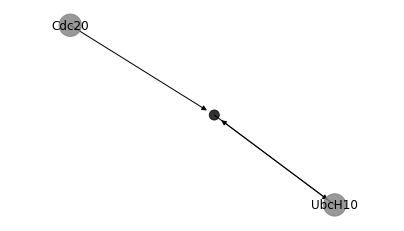

['CyclinA_UbcH10', 'UbcH10'] condition: {'CyclinA'}


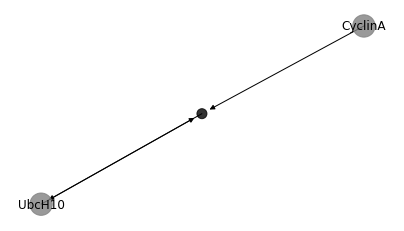

In [30]:
for csm,c in CSM_list:
    if len(set(c))==1:
        print  (csm,'condition:' ,set(c))
        G_CSM=G_expanded.subgraph(csm+c)
        plt.figure(figsize=(7,4))
        pos = nx.layout.kamada_kawai_layout(G_CSM)  # positions for all nodes
        nx.draw_networkx_nodes(G_CSM,pos,alpha=0.8, node_size=[100 if '_' in i else 500 for i in G_CSM.nodes()],node_color=['black' if '_' in i else 'grey' for i in G_CSM.nodes()])
        nx.draw_networkx_edges(G_CSM, pos)
        # labels
        nx.draw_networkx_labels(G_CSM, pos, labels={i:'' if '_' in i else i for i in G_CSM})

        plt.axis('off')
        plt.show()


### The Logic Domain of Influence (LDOI) of CSMs

In [31]:
output_list=[]
for csm, c in CSM_list:
    LDOI=BDOI.truncated_node_of_influence_BFS(G_expanded,csm+list(set(c)))[0]
    number_of_conditions=len(set(c))
    states_in_CSM=[i for i in csm if '_' not in i]
    number_of_states=len(states_in_CSM)
    output_list.append([states_in_CSM, set(c), number_of_conditions,number_of_states,LDOI])
    
df=pd.DataFrame(output_list, columns=['CSM_States','condition(s)','number_of_conditions','number_of_states', 'LDOI'])
df=df.sort_values(['number_of_conditions','number_of_states'])
df

,CSM_States,condition(s),number_of_conditions,number_of_states,LDOI
12,[~pAPC],{~CyclinB},1,1,"{~pAPC, ~CyclinB_~Cdc20, ~Cdc20, ~CyclinB_~pAPC}"
14,[pAPC],{Cdc20},1,1,"{Cdc20_pAPC, Cdh1, ~Cdc25C, pAPC, ~Cdk1_~Cycli..."
21,[~UbcH10],{Cdh1},1,1,"{~UbcH10, ~UbcH10_Cdh1, ~CyclinB_~Cdc20, Cdk1,..."
22,[~pAPC],{~Cdk1},1,1,"{~pAPC, ~Cdk1_~pAPC, ~Cdk1_~Cdc20, ~Cdc20}"
25,[UbcH10],{CyclinB},1,1,"{UbcH10_CyclinB, UbcH10}"
26,[UbcH10],{Cdc20},1,1,"{Cdc20_UbcH10, UbcH10}"
27,[UbcH10],{CyclinA},1,1,"{~Cdh1, Cdk1, CyclinA_UbcH10, Cdc25C_CyclinA, ..."
2,"[~CyclinB, Cdh1]",{~CyclinA},1,2,"{~UbcH10, Cdh1, ~Cdc25C, ~CyclinB_~Cdc20, ~Cdc..."
3,"[~pAPC, ~Cdc20]",{~Cdk1},1,2,"{~pAPC, ~Cdk1_~pAPC, ~Cdk1_~Cdc20, ~Cdc20}"
5,"[Cdc25C, Cdk1]",{CyclinB},1,2,"{Cdc20_pAPC, ~Cdh1, Cdc20_UbcH10, Cdk1, pAPC, ..."


In [32]:
df.to_excel('conditionally_stable_motifs.xlsx',index=False)